# Methods and models for multivariate data analysis. Lab 2

## <font color='darkblue'> **Aleksandr Shirokov, J4133c** </font>

In [26]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import statsmodels
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats.distributions import norm

from definitions import ROOT_DIR

%matplotlib inline

SAVE = False

In [2]:
for library in [np, pd, sns, scipy, sklearn, statsmodels]:
    print(f'{library.__name__}=={library.__version__}')

numpy==1.20.1
pandas==1.2.3
seaborn==0.11.2
scipy==1.6.1
sklearn==1.0.1
statsmodels==0.13.1


## Dataset

To use dataset you need:

- Download dataset from this [link](https://www.kaggle.com/devbcdestiller/bitcoin-usdt-price-trend-indicators) and save it in `data` folder with filename `data.csv`

- Apply several feature engineering using code below:

In [3]:
DATA_PATH = ROOT_DIR / 'data'

REPORT_FOLDER = ROOT_DIR / 'docs' / 'report' / 'images'

data = pd.read_csv(DATA_PATH / 'data.csv')

**Feature engineering for dataset**

In [4]:
data['quantile_Volume'] = pd.qcut(data['Volume'], q=4)
data['quantile_RSI'] = pd.qcut(data['RSI'], q=4)
data['quantile_STOCHRSI-K'] = pd.qcut(data['STOCHRSI-K'], q=4)
data['quantile_STOCHRSI-D'] = pd.qcut(data['STOCHRSI-D'], q=4)
data['month'] = data.dt.apply(lambda x: pd.to_datetime(x).month)
data = data.drop('dt', axis=1)

## Additional Data Preprocessing

In [5]:
quantile_map = dict(
    zip(
        map(
            lambda x: str(x), 
            np.sort(data['quantile_Volume'].unique())
        ), 
        range(1, 5)
    )
)
quantile_map

{'(5.885999999999999, 1560.863]': 1,
 '(1560.863, 2298.493]': 2,
 '(2298.493, 3550.281]': 3,
 '(3550.281, 44239.812]': 4}

In [6]:
columns = data.columns

target = ['Close']
features = ['Open', 'Volume', 'RSI', 'MACD Signal', 'month', 'STOCHRSI-D']
categories = ['quantile_Volume']

In [7]:
data['quantile_Volume']= data['quantile_Volume'].astype(str).map(quantile_map)

In [8]:
for col in features + categories:
    data[col] = data[col].fillna(data[col].median())

In [9]:
data = data[features + categories + target]
columns = features + categories + target

## Subtask 1.


*Non-parametric estimation of PDF in:*

- form of histogram

- using kernel density function for MRV (or probability law in case of discrete MRV)

Firstly let's show the histograms of each variable.

In [10]:
pair_columns = [
    x for x in columns if x not in 
    ['quantile_Volume', 'month']
] # this variables are categorical

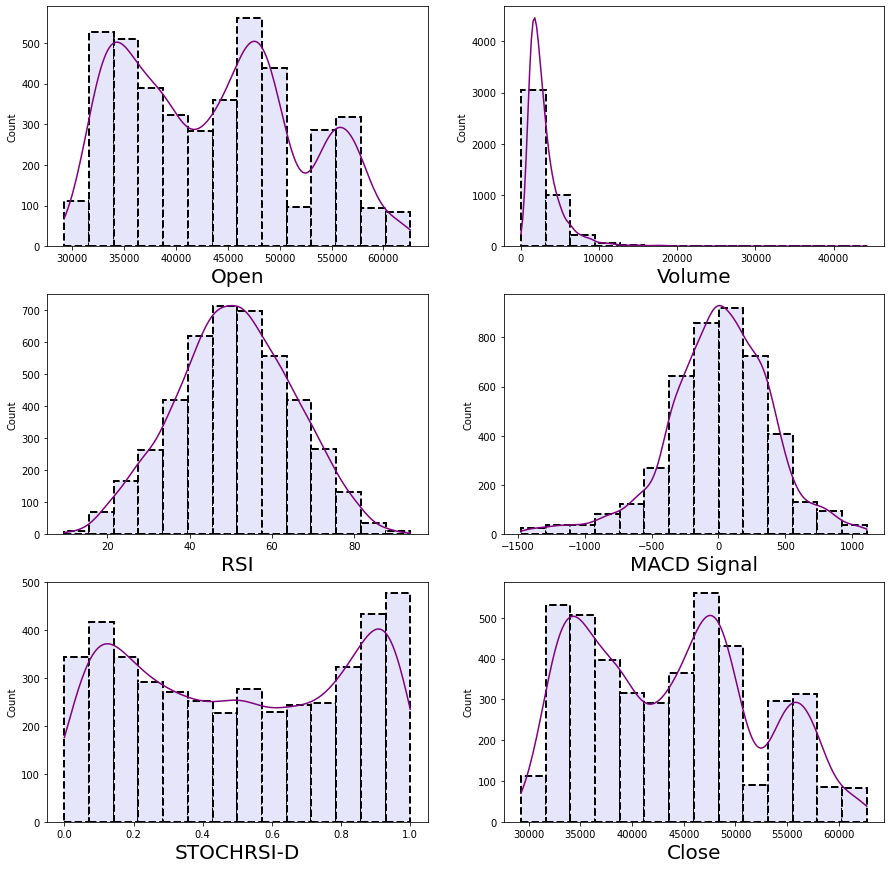

In [13]:
hist_plot_kwargs ={
    'color':'lavender', 
    'edgecolor':'black',
    'linewidth':2, 
    'linestyle':'--', 
    'alpha':1
}

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

for ax, cols in zip(axes.flat, pair_columns):
    b = sns.histplot(
        data[cols], 
        ax=ax, 
        bins='sturges',
        kde=True,
        **hist_plot_kwargs,
    )
    ax.lines[0].set_color('purple')
    ax.set_xlabel(cols, fontsize=20)

if SAVE:
    plt.savefig(REPORT_FOLDER / 'task_1_hist.png')
    
plt.show()

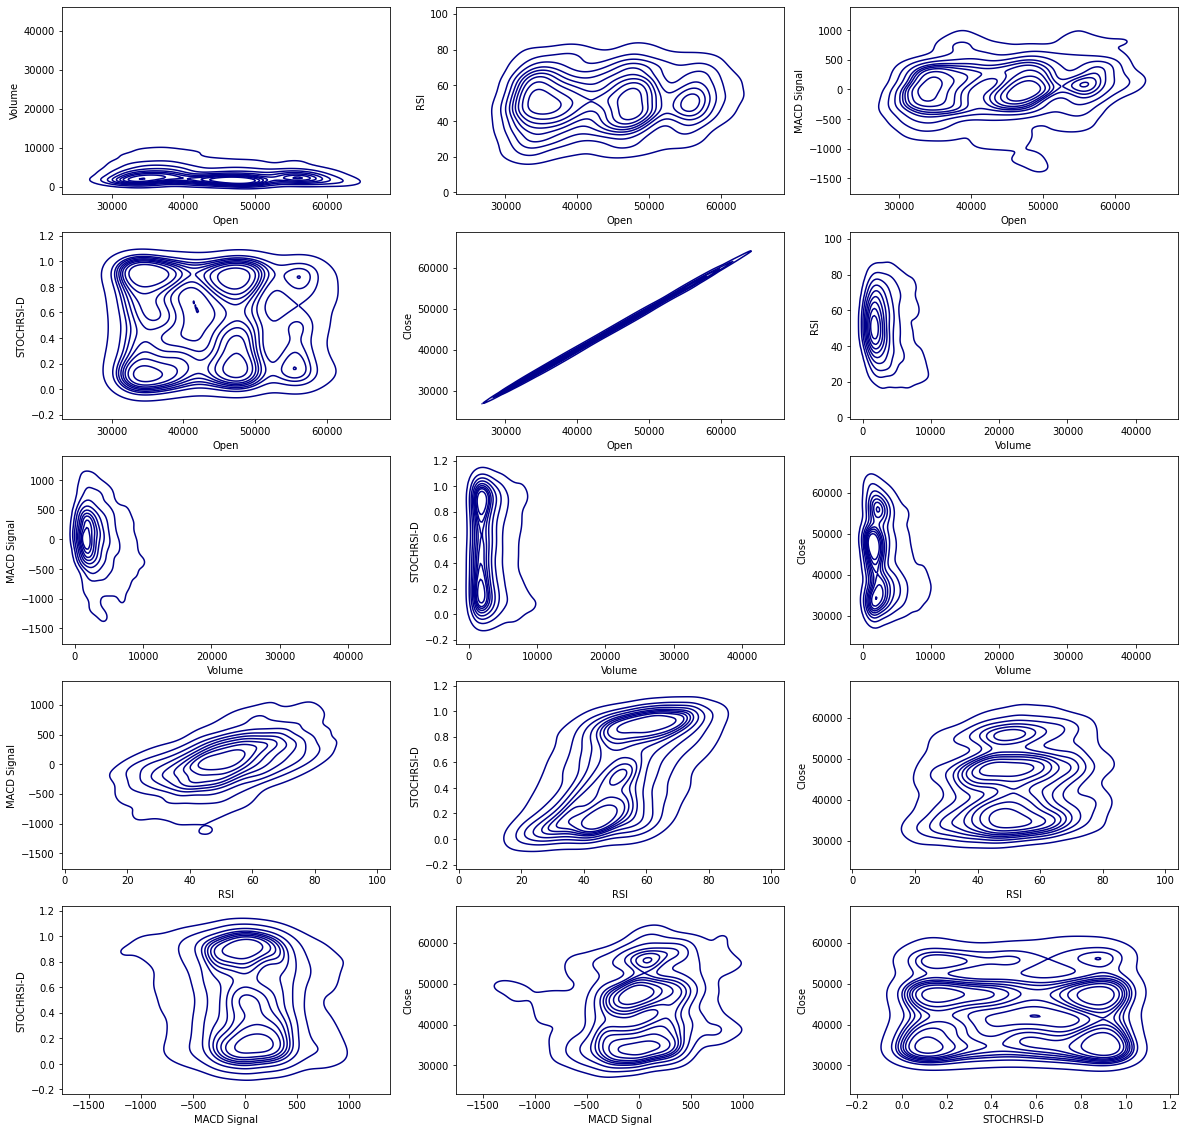

In [14]:
from itertools import combinations

pairs = list(combinations(pair_columns, 2))


fig, axes = plt.subplots(5, 3, figsize=(20, 20))
for ax, (col1, col2) in zip(axes.flat, pairs):
    sns.kdeplot(
        data=data, 
        x=data[col1], 
        y=data[col2],
        palette='BuPu',
        color='darkblue',
        ax=ax
    )
    
if SAVE:
    plt.savefig(REPORT_FOLDER / f'kde_pairs.png')
    
plt.show()

## Subtask 2.

*An estimation of multivariate mathematical expectation and variance*.


In [15]:
data[columns].mean()

Open               43744.748055
Volume              3018.940768
RSI                   50.929004
MACD Signal            9.319127
month                  7.101575
STOCHRSI-D             0.510336
quantile_Volume        2.499658
Close              43746.064022
dtype: float64

In [16]:
data[columns].var()

Open               6.876476e+07
Volume             6.748538e+06
RSI                2.007612e+02
MACD Signal        1.496410e+05
month              3.127351e+00
STOCHRSI-D         9.952140e-02
quantile_Volume    1.250514e+00
Close              6.880793e+07
dtype: float64

## Subtask 3.

*Non-parametric estimation of conditional distributions, mathematical expectations and variances.*

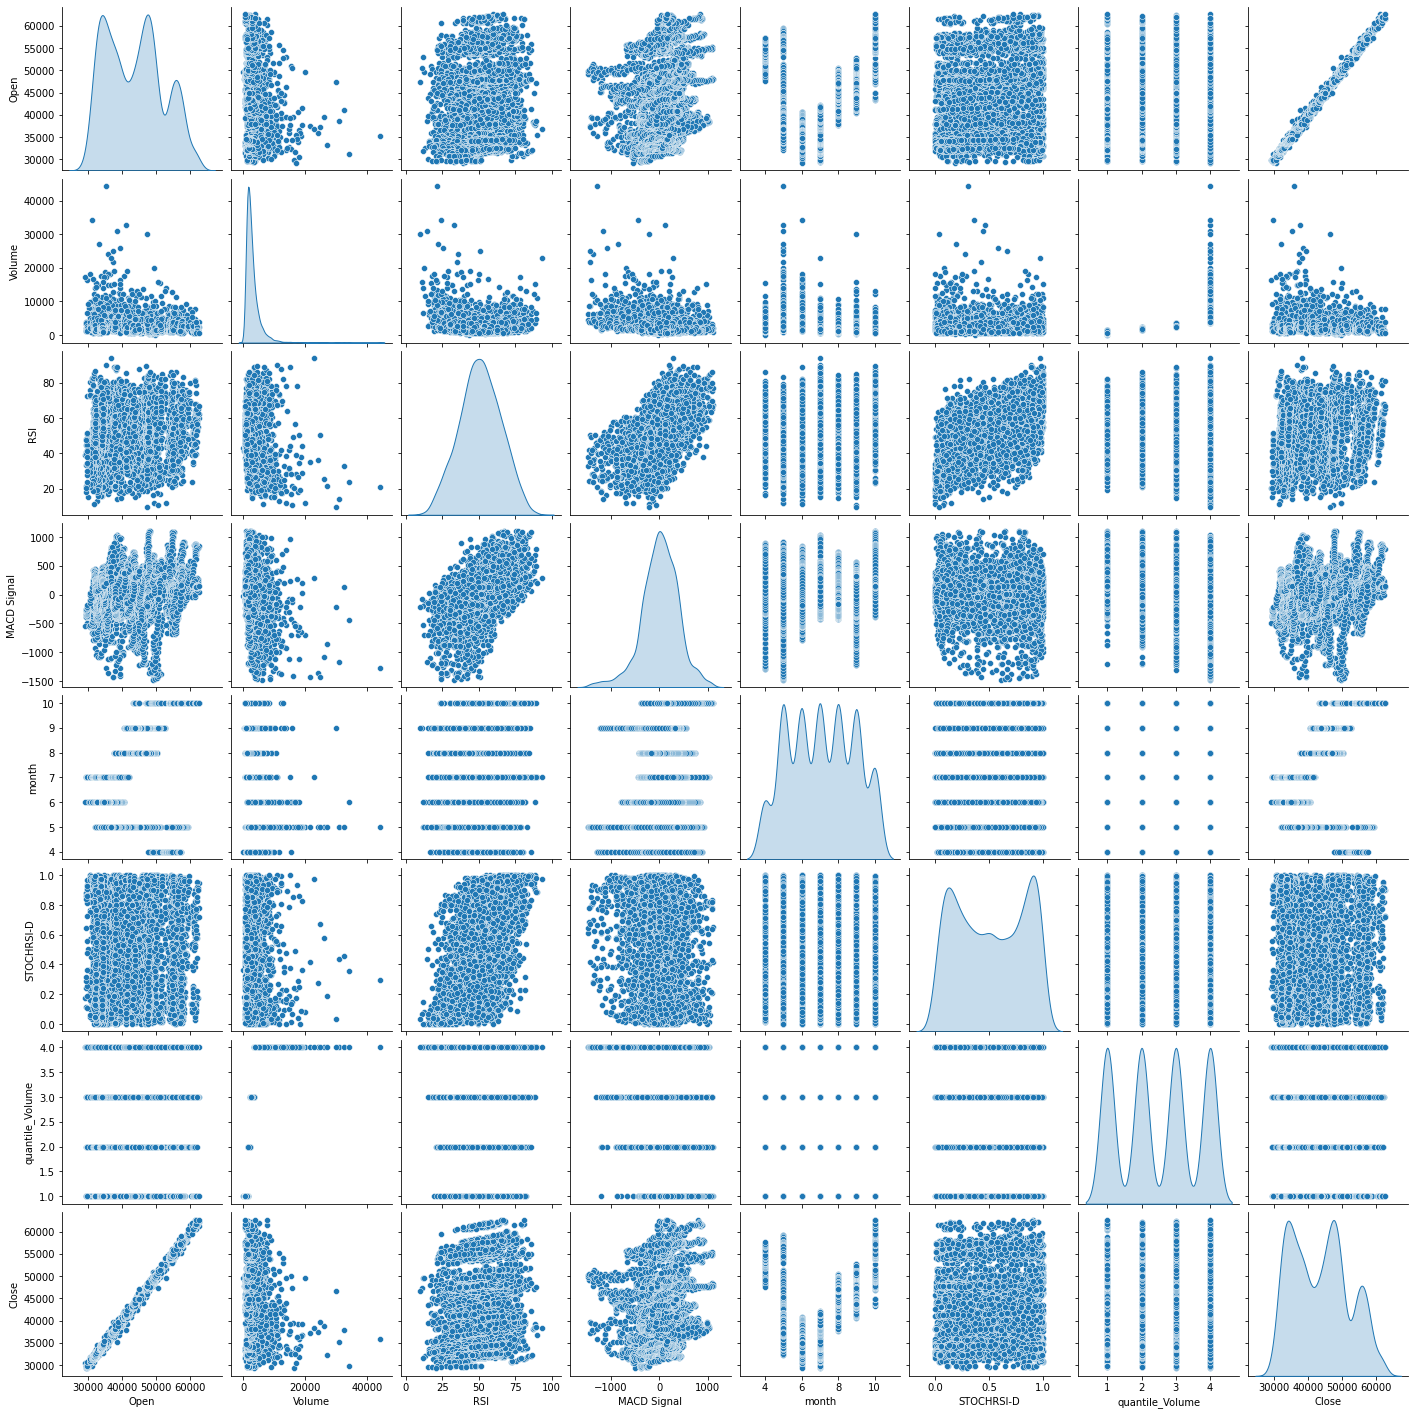

In [15]:
sns.pairplot(data[columns], diag_kind='kde', palette='BuPu')

if SAVE:
    plt.savefig(REPORT_FOLDER / f'distr.png')

plt.show()

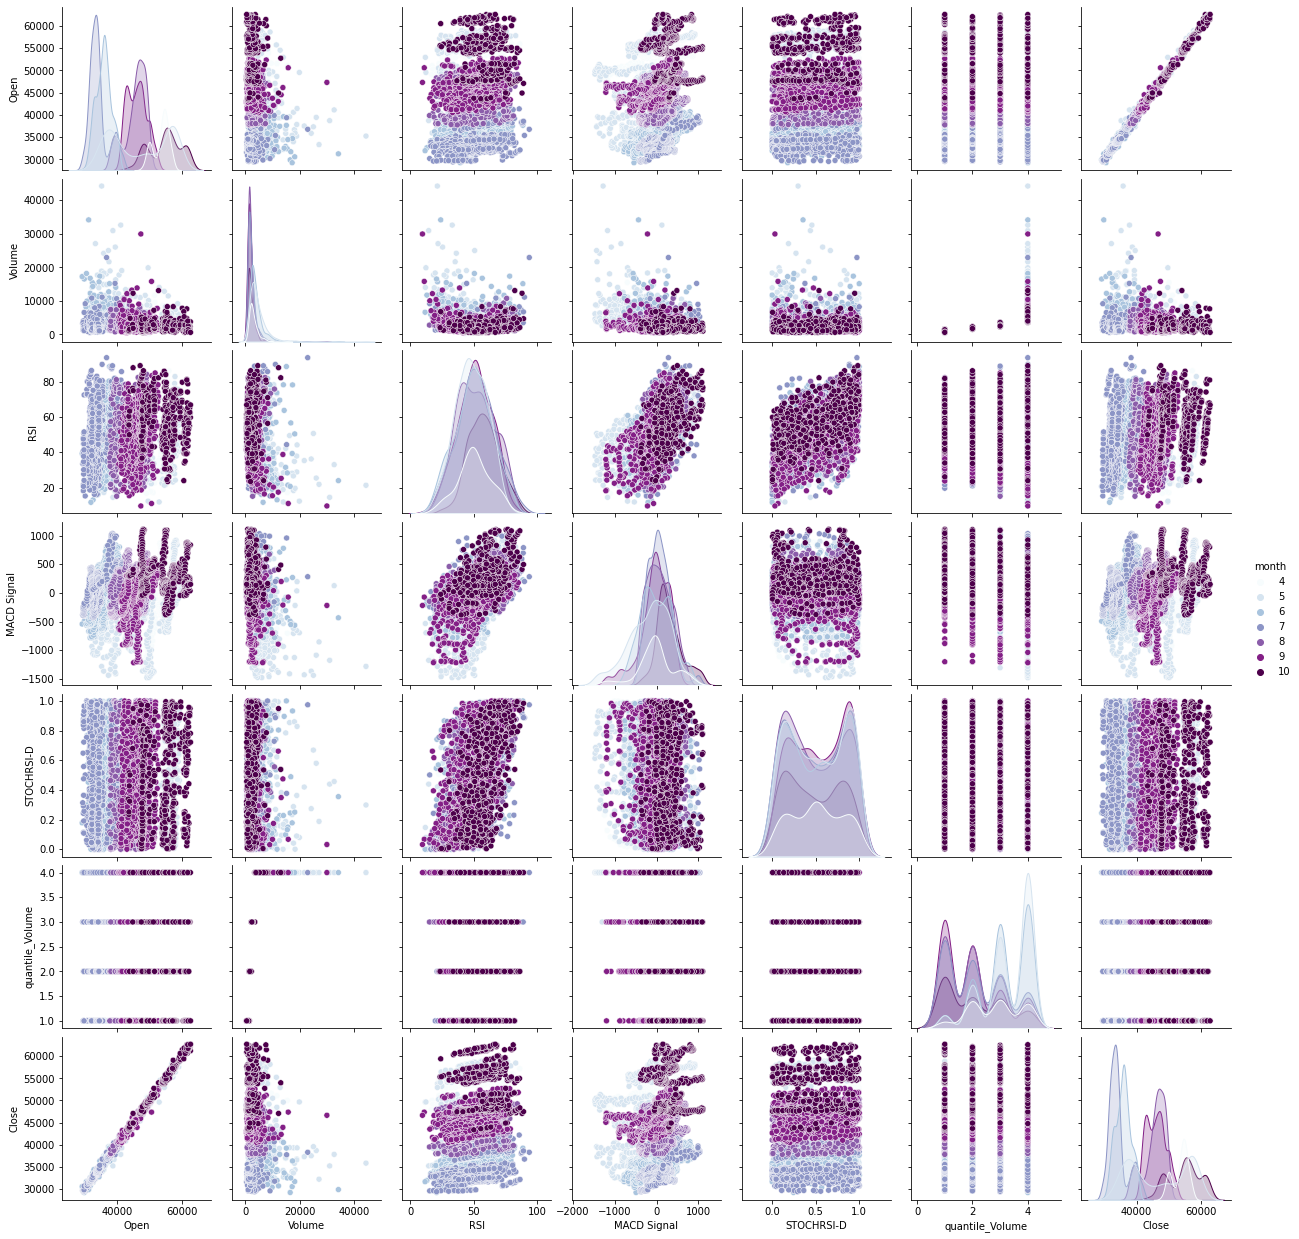

In [16]:
sns.pairplot(data[columns], diag_kind='kde', palette='BuPu', hue='month')

if SAVE:
    plt.savefig(REPORT_FOLDER / f'distr_hue_month.png')

plt.show()

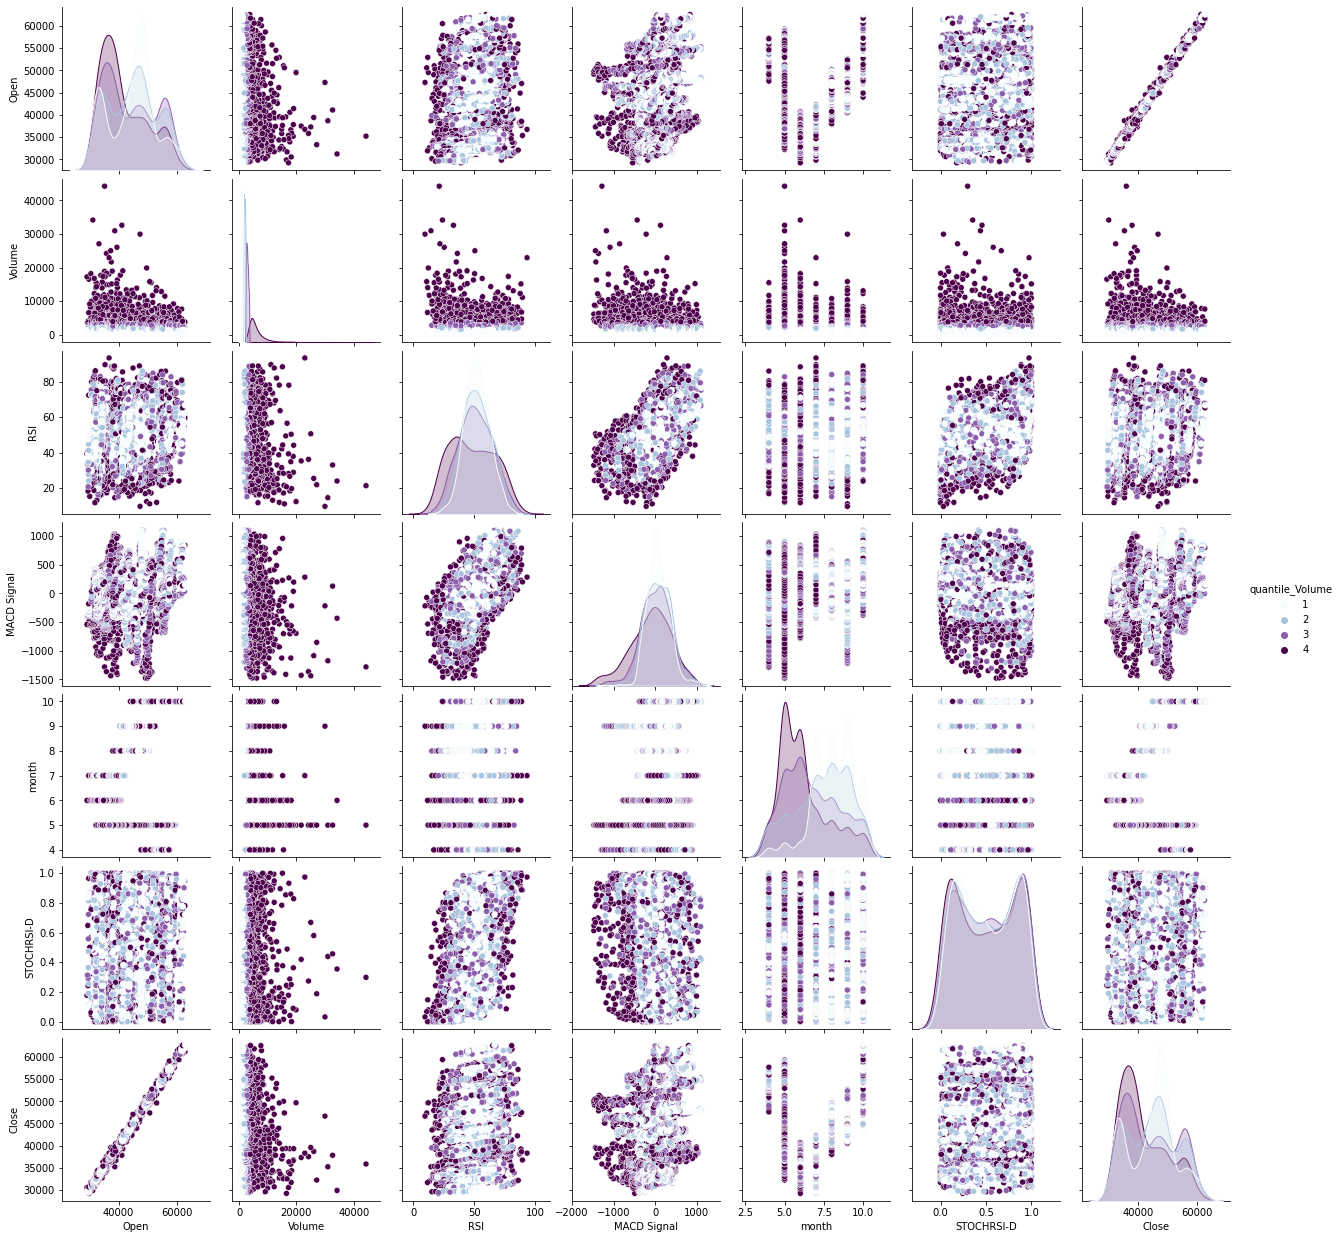

In [17]:
sns.pairplot(data[columns], diag_kind='kde', palette='BuPu', hue='quantile_Volume')

if SAVE:
    plt.savefig(REPORT_FOLDER / f'distr_hue_quantile_volume.png')

plt.show()

**Conditional distributions**

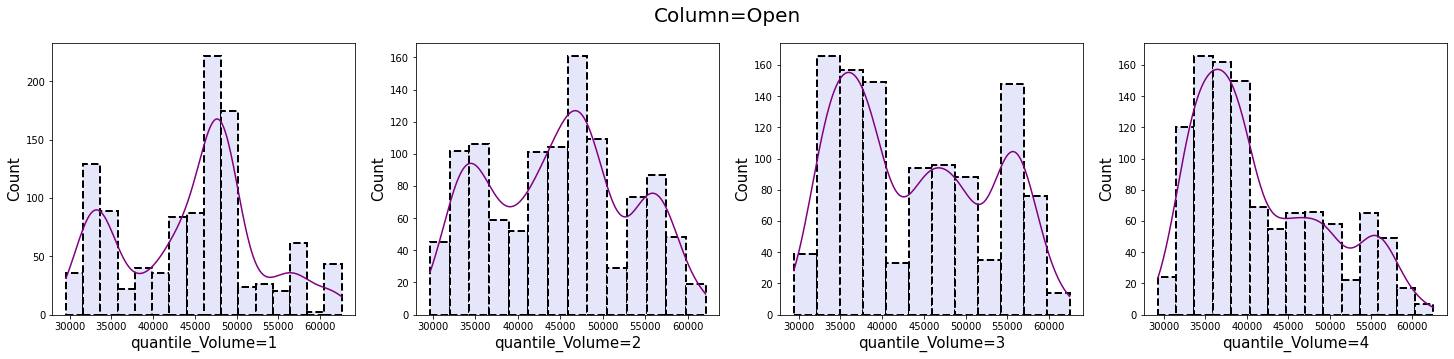

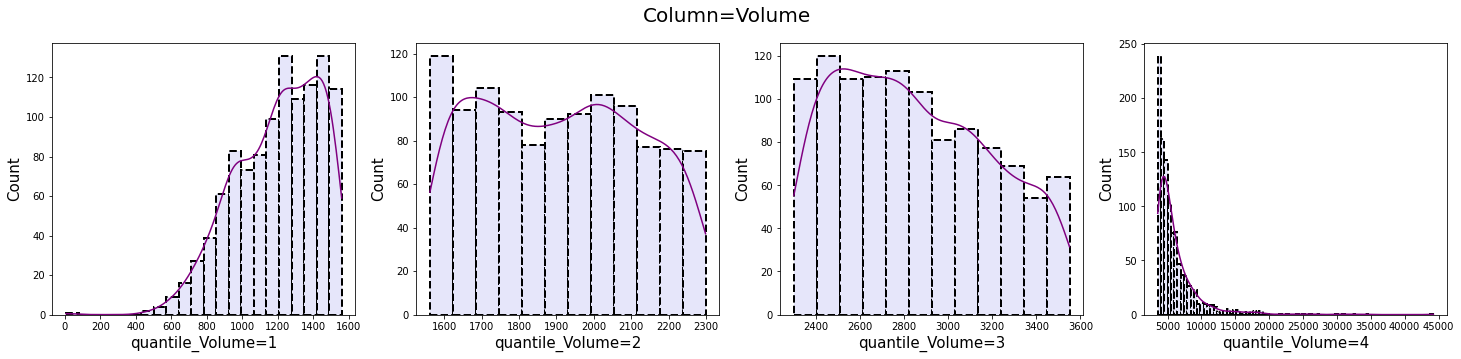

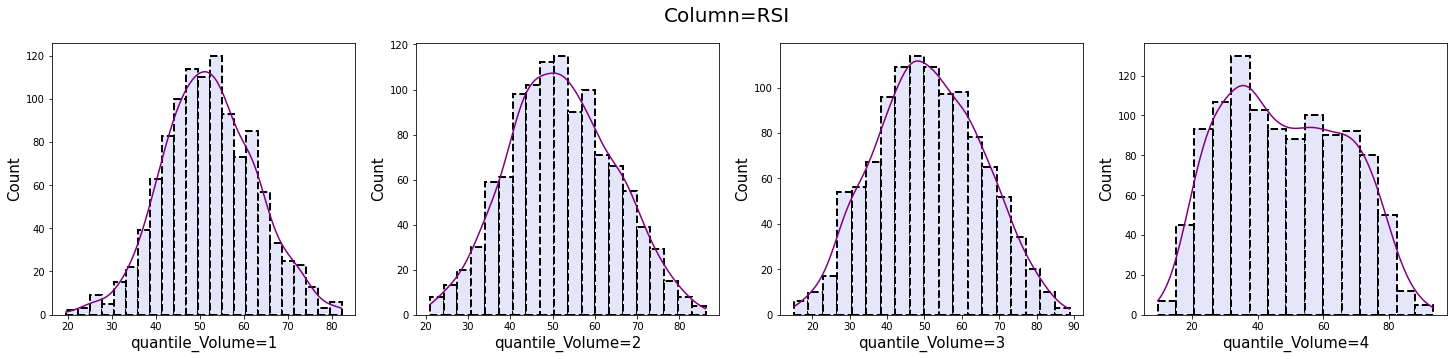

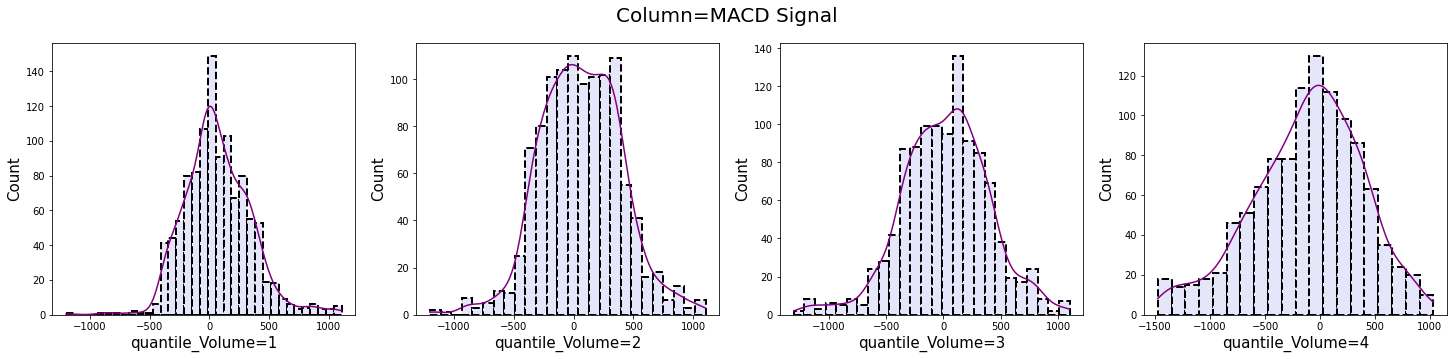

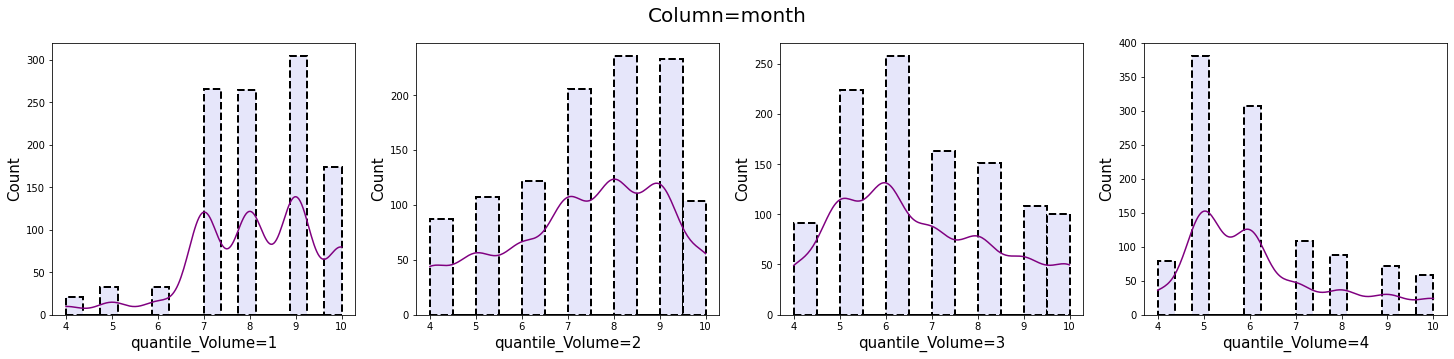

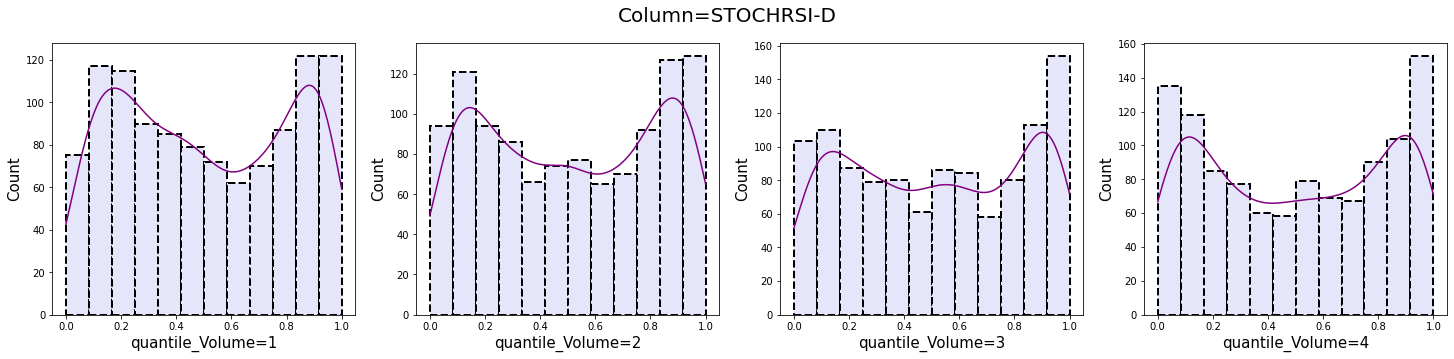

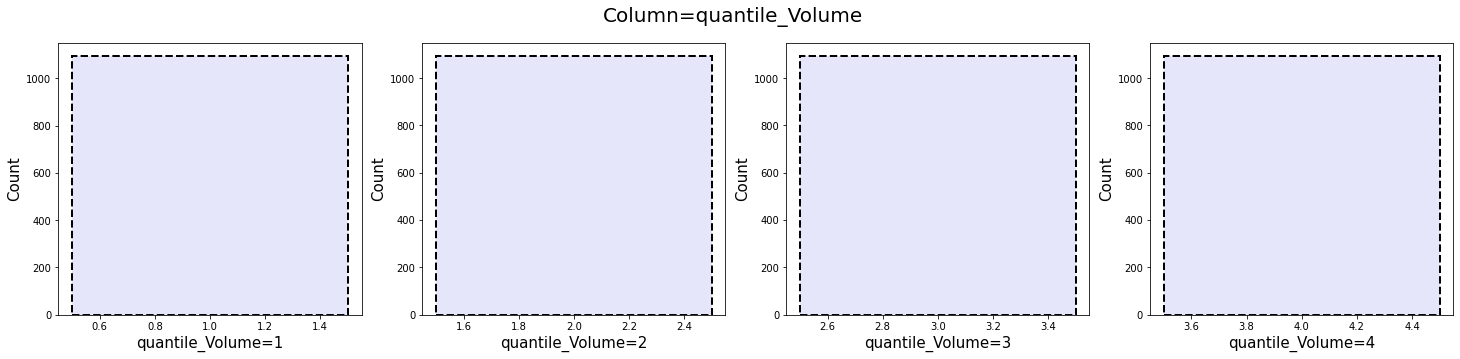

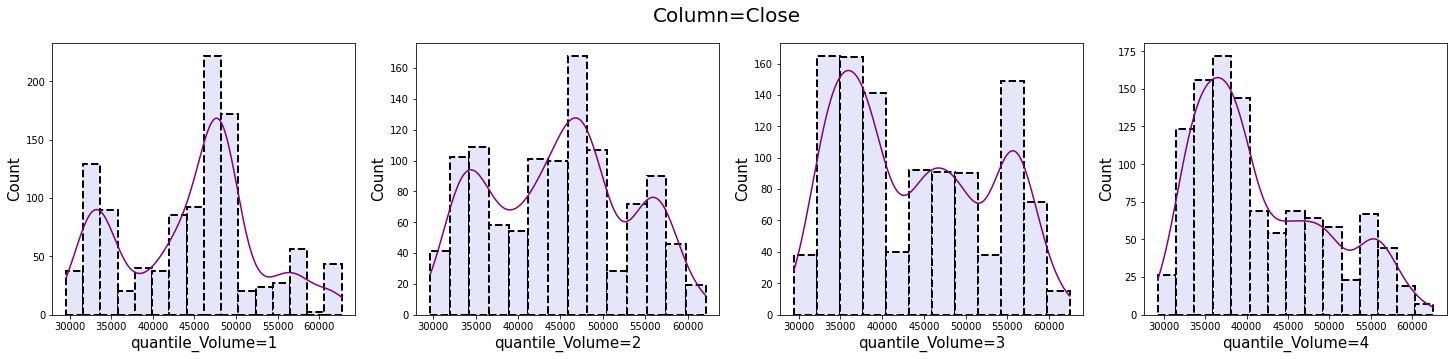

In [17]:
conditions = np.sort(data['quantile_Volume'].unique())

for col in columns:
    fig, ax = plt.subplots(1, 4, figsize=(25, 5))
    for ax, cols in zip(ax.flat, conditions):

        condition_df = data[
            data['quantile_Volume'] == cols
        ]
        sns.histplot(
            condition_df[col],
            ax=ax,
            kde=True,
            **hist_plot_kwargs
        )
        ax.set_xlabel(f'quantile_Volume={cols}', fontsize=15)
        ax.set_ylabel('Count', fontsize=15)
        try:
            ax.lines[0].set_color('purple')
        except:
            continue
        
    fig.suptitle(f'Column={col}', fontsize=20)
    
    if SAVE:
        plt.savefig(REPORT_FOLDER / f'conditional_distr_column_{col}.png')
    
    plt.show()

Let's count mathematical expectation and variance of conditional distribution and show it in table.

In [18]:
cond_mean = {}
cond_var = {}

for condition in conditions:
    condition_df = (
        data[data['quantile_Volume'] == condition]
        .drop('quantile_Volume', axis=1)
    )
    df_mean = condition_df.var(axis=0)
    df_mean.index = [f'mean_{x}' for x in df_mean.index]
    df_var = condition_df.mean(axis=0)
    df_var.index = [f'var_{x}' for x in df_var.index]
    cond_mean[f'quantile_Volume={condition}'] = df_mean
    cond_var[f'quantile_Volume={condition}'] = df_var

In [19]:
pd.DataFrame(cond_mean)

quantile_Volume=1  quantile_Volume=2  quantile_Volume=3  \
mean_Open              6.470311e+07       6.686893e+07       7.559168e+07   
mean_Volume            5.712776e+04       4.520472e+04       1.198644e+05   
mean_RSI               1.078101e+02       1.530043e+02       1.963207e+02   
mean_MACD Signal       7.512455e+04       1.122182e+05       1.432975e+05   
mean_month             1.830923e+00       2.996524e+00       3.077789e+00   
mean_STOCHRSI-D        9.287287e-02       9.792741e-02       9.968853e-02   
mean_Close             6.472727e+07       6.693694e+07       7.560658e+07   

                  quantile_Volume=4  
mean_Open              6.151362e+07  
mean_Volume            1.261243e+07  
mean_RSI               3.359093e+02  
mean_MACD Signal       2.466097e+05  
mean_month             2.480985e+00  
mean_STOCHRSI-D        1.077437e-01  
mean_Close             6.151082e+07

In [20]:
pd.DataFrame(cond_var)

quantile_Volume=1  quantile_Volume=2  quantile_Volume=3  \
var_Open              44555.475383       44868.400411       43955.143799   
var_Volume             1202.160961        1909.361322        2847.455732   
var_RSI                  52.202464          52.222315          51.065099   
var_MACD Signal          69.277297          64.243045          17.243959   
var_month                 8.128650           7.380822           6.715068   
var_STOCHRSI-D            0.506549           0.513545           0.517946   
var_Close             44567.078905       44867.676795       43960.847087   

                 quantile_Volume=4  
var_Open              41599.232237  
var_Volume             6118.444216  
var_RSI                  48.224974  
var_MACD Signal        -113.542551  
var_month                 6.180822  
var_STOCHRSI-D            0.503308  
var_Close             41587.903516

## Subtask 4.

*An estimation of pair correlation coefficients, confidence intervals for them and significance levels.*

Let's visualise correlation matrix

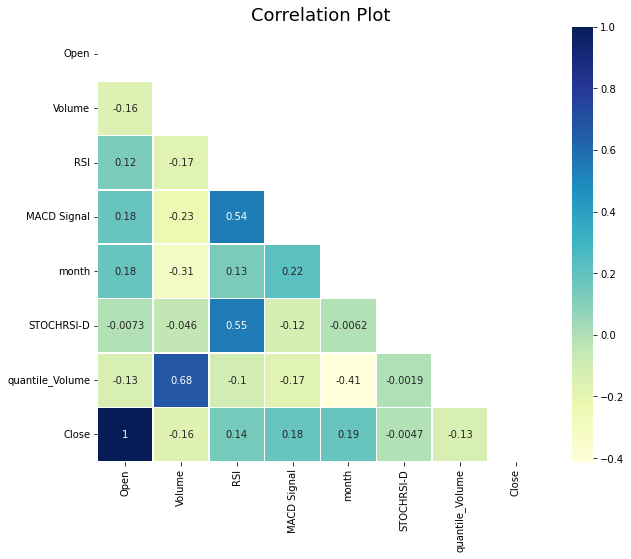

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))

corr = data[columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, 
            mask=mask, 
            annot=True, 
            ax=ax, 
            vmax=1, 
            fmt='.2g', 
            linewidths=.5,
            cmap="YlGnBu")

ax.set_title('Correlation Plot', fontsize=18)

if SAVE:
    plt.savefig(REPORT_FOLDER / f'correlation_plot.png')

plt.show()

In [22]:
import copy

corr_coef = copy.deepcopy(corr)
corr_coef = corr_coef.astype(object)

Let $x_i, y_i$ have $2$-dimensional distributuion and $r$ is correlation coefficient. When $n \to \infty$, statistic:

$$z = \frac{1}{2}\ln\frac{1+r}{1-4} = Arth(r) \sim N\left(Arth(r), \frac{1}{\sqrt{n-3}}\right)$$

where Arth - the hyperbolic arctangent.

Confidence interval for $Arth(\rho)$ is:

$$Arth(r) - \frac{u_{1 - \frac{\alpha}{2}}}{\sqrt{n-3}} < Arth(\rho) < Arth(r) + \frac{u_{1 - \frac{\alpha}{2}}}{\sqrt{n-3}}$$

So

$$Th\left(Arth(r) - \frac{u_{1 - \frac{\alpha}{2}}}{\sqrt{n-3}}\right) < \rho < Th\left(Arth(r) + \frac{u_{1 - \frac{\alpha}{2}}}{\sqrt{n-3}}\right)$$

And count confidence interval for each correlation.

In [23]:
from scipy import stats

alpha = 0.05

for index, col in enumerate(columns):
    for k in range(index + 1, len(columns)):
        col2 = columns[k]
        x1, x2 = data[col], data[col2]
        coeff, p = stats.pearsonr(x1, x2)
        
        std = 1 / np.sqrt(x1.size-3)
        z = stats.norm.ppf(1 - alpha / 2)
        coeff_z = np.arctanh(coeff)
        
        low_z, high_z = np.tanh(coeff_z - z * std), np.tanh(coeff_z + z * std)
        
        output_string = f'({low_z:.3}, {high_z:.3})'
        corr_coef.at[col, col2] = output_string
        corr_coef.at[col2, col] = output_string

corr_coef.values[tuple([np.arange(corr_coef.shape[0])]*2)] = '(1.0, 1.0)'

DataFrame of confidence interval (left and right interval for coefficient)

In [24]:
corr_coef

Open              Volume                RSI  \
Open                    (1.0, 1.0)    (-0.189, -0.131)    (0.0945, 0.153)   
Volume            (-0.189, -0.131)          (1.0, 1.0)     (-0.2, -0.143)   
RSI                (0.0945, 0.153)      (-0.2, -0.143)         (1.0, 1.0)   
MACD Signal         (0.156, 0.213)    (-0.262, -0.207)      (0.518, 0.56)   
month               (0.155, 0.213)    (-0.341, -0.287)     (0.101, 0.159)   
STOCHRSI-D       (-0.0369, 0.0223)  (-0.0757, -0.0166)     (0.524, 0.566)   
quantile_Volume   (-0.161, -0.103)      (0.659, 0.691)  (-0.133, -0.0739)   
Close               (0.999, 0.999)    (-0.193, -0.135)     (0.113, 0.171)   

                      MACD Signal              month          STOCHRSI-D  \
Open               (0.156, 0.213)     (0.155, 0.213)   (-0.0369, 0.0223)   
Volume           (-0.262, -0.207)   (-0.341, -0.287)  (-0.0757, -0.0166)   
RSI                 (0.518, 0.56)     (0.101, 0.159)      (0.524, 0.566)   
MACD Signal            (1.0, 1.0)     (0.192, 0.248)    (-0.145, -0.087)   
month              (0.192, 0.248)         (1.0, 1.0)   (-0.0358, 0.0234)   
STOCHRSI-D       (-0.145, -0.087)  (-0.0358, 0.0234)          (1.0, 1.0)   
quantile_Volume  (-0.201, -0.143)   (-0.436, -0.387)   (-0.0315, 0.0277)   
Close              (0.156, 0.213)     (0.157, 0.214)   (-0.0343, 0.0249)   

                   quantile_Volume              Close  
Open              (-0.161, -0.103)     (0.999, 0.999)  
Volume              (0.659, 0.691)   (-0.193, -0.135)  
RSI              (-0.133, -0.0739)     (0.113, 0.171)  
MACD Signal       (-0.201, -0.143)     (0.156, 0.213)  
month             (-0.436, -0.387)     (0.157, 0.214)  
STOCHRSI-D       (-0.0315, 0.0277)  (-0.0343, 0.0249)  
quantile_Volume         (1.0, 1.0)   (-0.162, -0.103)  
Close             (-0.162, -0.103)         (1.0, 1.0)

## Subtask 5 + 6.

**Task formulation**:

Due to results in previous subtak, we will try to predict target column `Close` by columns:

```python
columns = [
    'Open',
    'Volume',
    'RSI', 
    'MACD Signal', 
    'month', 
    'quantile_Volume'
]
```

without `STOCHRSI-D` because of low correlation.

In [25]:
X = data[features + categories].drop('STOCHRSI-D', axis=1) # predictors
y = data[target] # target

## Regression

We are applying cross validation in 10 Folds for regression model with different splits on train ann test size.

In [38]:
mae = []
rmse = []
r2s = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.2, 
        random_state=i, 
        shuffle=True
    )
    lr = make_pipeline(
        StandardScaler(with_mean=False), 
        LinearRegression()
    )
    lr.fit(X_train, y_train)

    prediction = lr.predict(X_test)
    mae.append(
        mean_absolute_error(y_test, prediction)
    )
    rmse.append(
        mean_squared_error(y_test, prediction, squared=False)
    )
    r2s.append(
        r2_score(y_test, prediction)
    )

print(f'Mean MAE = {np.mean(mae)}')
print(f'Mean RMSE = {np.mean(rmse)}')
print(f'Mean R2 = {np.mean(r2s)}')

Mean MAE = 245.69528287586203
Mean RMSE = 341.0056393358944
Mean R2 = 0.9982962627816183


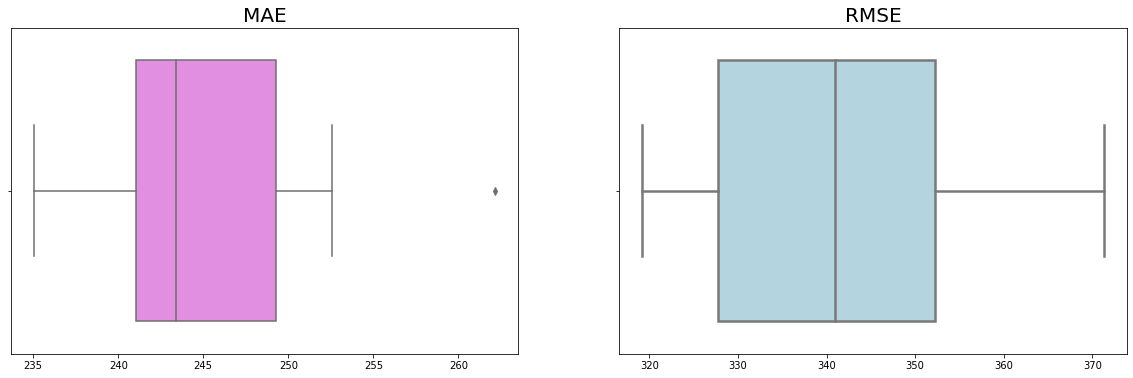

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.boxplot(x=mae, ax=ax[0], color='violet')
sns.boxplot(x=rmse, ax=ax[1], linewidth=2.5, color='lightblue')
ax[0].set_title('MAE', fontsize=20)
ax[1].set_title('RMSE', fontsize=20)
plt.show()

## Lasso

Let's find the best value for alpha with Lasso Regression - we believe, that model will not overfitted on only one feature.

In [35]:
import typing as t

def find_best_alpha(
    sklearn_model: t.Union[Lasso, Ridge], 
    alphas: np.array = None,
    test_size: float = 0.2
):
    if alphas is None:
        alphas = np.linspace(0.001, 5, 100)
    
    best_rmse = float('inf')
    best_alpha = float('inf')
    best_mae = float('inf')
    best_r2 = -float('inf')
    
    for alpha in alphas: 
        mae = []
        rmse = []
        model = sklearn_model(alpha=alpha, max_iter=10000000)
        for i in range(10):
            X_train, X_test, y_train, y_test = train_test_split(
                X, 
                y, 
                test_size=test_size, 
                random_state=i, 
                shuffle=True
            )
            model.fit(X_train, y_train)
            prediction = model.predict(X_test)
            mae.append(
                mean_absolute_error(y_test, prediction)
            )
            rmse.append(
                mean_squared_error(y_test, prediction, squared=False)
            )
            r2s.append(
                r2_score(y_test, prediction)
            )
        if np.mean(rmse) <= best_rmse:
            best_rmse = np.mean(rmse)
            best_alpha = alpha
            best_mae = np.mean(mae)
            best_r2 = np.mean(r2s)
            
    print(f'Best alpha {sklearn_model.__name__} Regression = {best_alpha}')
    print(f'Best rmse {sklearn_model.__name__} Regression = {best_rmse}')
    print(f'Best mae {sklearn_model.__name__} Regression = {best_mae}')
    print(f'Best R2 {sklearn_model.__name__} Regression = {best_r2}')
    
    return best_alpha, best_rmse, best_mae, best_r2

In [36]:
best_alpha_lasso, best_rmse_lasso, best_mae_lasso, best_r2_lasso = find_best_alpha(Lasso)

Best alpha Lasso Regression = 4.798020202020202
Best rmse Lasso Regression = 340.92498574885997
Best mae Lasso Regression = 245.61776749907045
Best R2 Lasso Regression = 0.9982966004150984


## Ridge Regression

The same for ridge regression.

In [37]:
best_alpha_ridge, best_rmse_ridge, best_mae_ridge, best_r2_ridge = find_best_alpha(Ridge)

Best alpha Ridge Regression = 5.0
Best rmse Ridge Regression = 341.0039540706267
Best mae Ridge Regression = 245.69466536883382
Best R2 Ridge Regression = 0.9982965368756161


As we can see the best model is `LassoRegression` with coefficient of regularization `alpha=4.79`. Let's fit and find residulas for this model.

In [39]:
model = Lasso(
    alpha=best_alpha_lasso, 
    max_iter=1000
)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=0, 
    shuffle=True
)

predictions = np.array(lr.predict(X_train))
true_values = np.array(y_train)

residuals = true_values - predictions

In [40]:
RMSE, MAE, R2 = 'RMSE', 'MAE', 'R2'

result= {
    'LinReg': {RMSE: np.mean(rmse), MAE: np.mean(mae), R2: np.mean(r2s)}, 
    fr'Lasso($\alpha$={best_alpha_lasso:.3})': {RMSE: best_rmse_lasso, MAE: best_mae_lasso, R2: best_r2_lasso}, 
    fr'Ridge($\alpha$={best_alpha_ridge:.3})': {RMSE: best_rmse_ridge, MAE: best_mae_ridge, R2: best_r2_ridge}
}

In [54]:
np.mean(r2s) / (1 - np.mean(r2s)) * (4381 - 7 - 1) / 7

366048.1968734832

In [41]:
pd.DataFrame(result).T

RMSE         MAE        R2
LinReg               341.005639  245.695283  0.998296
Lasso($\alpha$=4.8)  340.924986  245.617767  0.998297
Ridge($\alpha$=5.0)  341.003954  245.694665  0.998297

In [56]:
from scipy.stats import probplot

[]

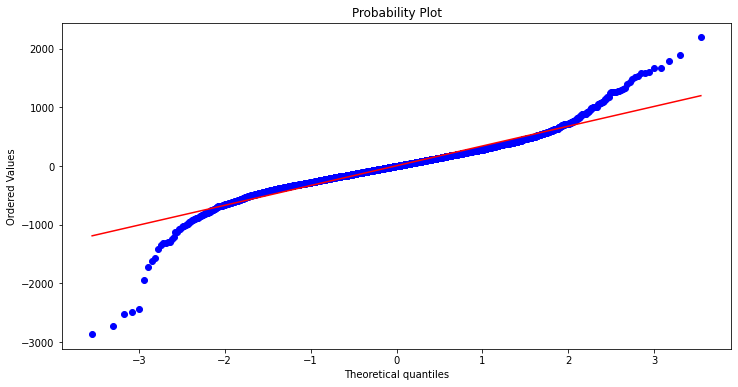

In [61]:
fig, ax = plt.subplots(1, 1, figsize = (12,6))

pe = probplot(
    residuals.ravel(), 
    dist="norm", 
    plot=ax
)

plt.plot()

## Subtask 7.

*Analyze the quality of regression model*


Calculate `Variance inflation factor`

In [42]:
from statsmodels.stats.outliers_influence import (
    variance_inflation_factor
)

In [43]:
vif_data = pd.DataFrame()
vif_data["features"] = X.columns
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i) 
    for i in range(len(X.columns))
]

In [44]:
vif_data

features        VIF
0             Open  21.201130
1           Volume   4.473409
2              RSI  15.427064
3      MACD Signal   1.308642
4            month  15.230902
5  quantile_Volume  10.358325

Let's seethe distribution of residuals - normal!

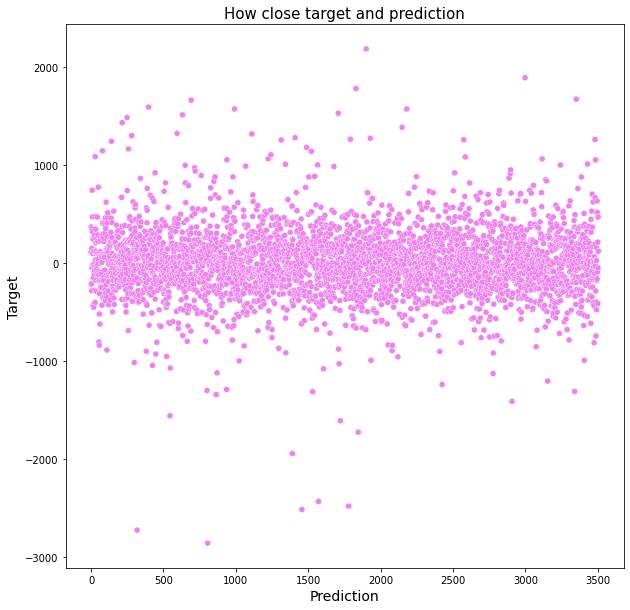

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(
    x=range(predictions.shape[0]), 
    y=residuals.ravel(), 
    ax=ax,
    color='violet',
    marker='o',
    linestyle='--'
)

ax.set_xlabel('Prediction', fontsize=14)
ax.set_ylabel('Target', fontsize=14)
ax.set_title('How close target and prediction', fontsize=15)

plt.savefig(REPORT_FOLDER / f'target_predict.png')
plt.show()

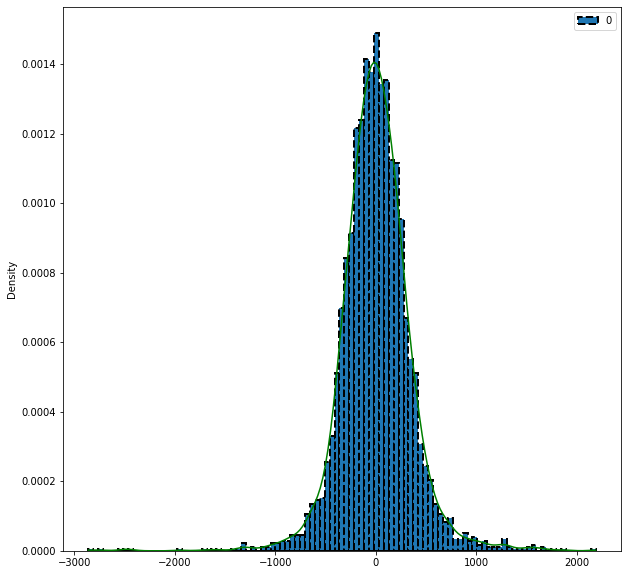

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.histplot(
    residuals, 
    ax=ax, 
    kde=True, 
    stat='density',
    **{**hist_plot_kwargs, 
       **{'color': 'lightblue'}}
)
ax.lines[0].set_color('green')

plt.savefig(REPORT_FOLDER / f'residuals.png')
plt.show()

In [47]:
from scipy.stats import shapiro, ttest_ind

shapiro(residuals)

ShapiroResult(statistic=0.9295549988746643, pvalue=8.527424680522784e-38)

In [49]:
mu = 0
mean = np.mean(residuals)
var = np.var(residuals)

T = np.abs(np.sqrt(len(residuals)) * (mean - mu) / var)

z = stats.t.ppf(1 - alpha / 2, len(residuals) - 1)

In [50]:
T, z

(0.002287033982773346, 1.9606414259263407)